In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core import display as ICD
import seaborn as sns
import glob
import scipy
import os
pd.set_option('display.max_columns', 100)

In [88]:
# import scikit learn packages

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

In [2]:
DATA_FOLDER = './avg_data/'

### Regression matrix creation

In [3]:
def vectorize_wind(df):
    u=np.array(df.iloc[:,0])
    dir_=np.array(df.iloc[:,1])
    df.iloc[:,:2]=pd.Dataframe(np.hstack)
    return 

In [4]:
os.listdir(DATA_FOLDER)

['surf_temp.txt',
 'radiometer.csv',
 'anem2.txt',
 'anem3.txt',
 'anem1.txt',
 'anem4.txt',
 'anem5.txt',
 'anem7.txt',
 'anem6.txt']

In [5]:
all_anem=glob.glob(DATA_FOLDER + "anem*")
mast_anem=all_anem[:6]
top_anem=all_anem[6]

In [6]:
only_mag=True
h=np.arange(1.5,22,4)
df_list=[]
for idx,i in enumerate(mast_anem):
    df_temp=pd.read_csv(i, sep=" ", header=None, index_col=0, names=['u','direction'])
    df_temp['h']=h[idx]
    df_list.append(df_temp)
mast_anem_df = pd.concat(df_list)
mast_anem_df.head()


,u,direction,h
2018-11-14 00:00:00,0.66,160.0,1.5
2018-11-14 00:01:00,0.69,187.0,1.5
2018-11-14 00:02:00,0.42,133.0,1.5
2018-11-14 00:03:00,0.58,179.0,1.5
2018-11-14 00:04:00,0.49,213.0,1.5


In [7]:
rad_df = pd.read_csv(DATA_FOLDER+'radiometer.csv', sep=" ",index_col=0)
temp_df = pd.read_csv(DATA_FOLDER+'surf_temp.txt', sep=" ",index_col=0)
top_anem_df = pd.read_csv(top_anem, sep=" ",index_col=0,names=['u_top','direction_top'])

In [8]:
time_var_df = top_anem_df.merge(rad_df,how='left', left_index=True,right_index=True)
time_var_df = time_var_df.merge(temp_df,how='left', left_index=True,right_index=True)
time_var_df.head()

,u_top,direction_top,Pyranometer Upper Irradiance [W/m$^2$],Pyranometer Lower Irradiance [W/m$^2$],Pyrgeometer Upper Irradiance [W/m$^2$],Pyrgeometer Lower Irradiance [W/m$^2$],Albedo [-],Net Solar radiation [W/m$^2$],Net (total) radiation [W/m$^2$],Net Far Infrared radiation [W/m$^2$],Sky temperature [°C],Radiometer Ground temperature [°C],Sensor Ground temperature [°C],North temperature [°C],East temperature [°C],South temperature [°C],West temperature [°C]
2018-11-14 00:00:00,2.76,298.0,1.8,-2.9,369.0,364.7,-1.1,4.7,9.0,4.3,10.9,10.0,10.5,13.1,11.8,11.6,10.5
2018-11-14 00:01:00,2.61,316.0,2.2,-0.0,371.7,365.8,0.6,2.2,8.1,5.9,11.4,10.3,10.5,13.1,11.8,11.6,10.5
2018-11-14 00:02:00,2.83,306.0,2.4,-2.1,370.7,366.0,-0.7,4.5,9.2,4.7,11.2,10.3,10.5,13.1,11.8,11.6,10.5
2018-11-14 00:03:00,2.24,259.0,1.6,-0.8,369.0,368.5,-0.1,2.4,3.0,0.5,10.9,10.8,10.5,13.1,11.8,11.6,10.6
2018-11-14 00:04:00,2.78,324.0,3.3,-2.6,370.0,365.9,0.1,5.9,10.0,4.1,11.1,10.3,10.5,13.1,11.8,11.6,10.6


In [9]:
tot_df=mast_anem_df.merge(time_var_df,how='left', left_index=True,right_index=True)
tot_df = tot_df.dropna(axis=0, how='any')
tot_df = tot_df.drop(columns=['Albedo [-]'])
tot_df.head()

,u,direction,h,u_top,direction_top,Pyranometer Upper Irradiance [W/m$^2$],Pyranometer Lower Irradiance [W/m$^2$],Pyrgeometer Upper Irradiance [W/m$^2$],Pyrgeometer Lower Irradiance [W/m$^2$],Net Solar radiation [W/m$^2$],Net (total) radiation [W/m$^2$],Net Far Infrared radiation [W/m$^2$],Sky temperature [°C],Radiometer Ground temperature [°C],Sensor Ground temperature [°C],North temperature [°C],East temperature [°C],South temperature [°C],West temperature [°C]
2018-11-14 00:00:00,0.66,160.0,1.5,2.76,298.0,1.8,-2.9,369.0,364.7,4.7,9.0,4.3,10.9,10.0,10.5,13.1,11.8,11.6,10.5
2018-11-14 00:00:00,0.91,225.0,5.5,2.76,298.0,1.8,-2.9,369.0,364.7,4.7,9.0,4.3,10.9,10.0,10.5,13.1,11.8,11.6,10.5
2018-11-14 00:00:00,0.57,185.0,9.5,2.76,298.0,1.8,-2.9,369.0,364.7,4.7,9.0,4.3,10.9,10.0,10.5,13.1,11.8,11.6,10.5
2018-11-14 00:00:00,2.64,284.0,13.5,2.76,298.0,1.8,-2.9,369.0,364.7,4.7,9.0,4.3,10.9,10.0,10.5,13.1,11.8,11.6,10.5
2018-11-14 00:00:00,2.98,313.0,17.5,2.76,298.0,1.8,-2.9,369.0,364.7,4.7,9.0,4.3,10.9,10.0,10.5,13.1,11.8,11.6,10.5


Here we are going to handle the albedo case if needed

In [10]:
# tot_df[tot_df['Albedo [-]']==-np.inf]
#tot_df.index[np.isinf(tot_df).any(1)]
#tot_df.columns.to_series()[np.isinf(tot_df).any()]
#plt.plot(tot_df['Albedo [-]'].drop(np.inf))
#tot_df[~tot_df.isin([np.inf, -np.inf]).any(1)]['Albedo [-]'].plot()

Transform absolute value and direction in vector components

In [11]:
# create columns with coordinate velocities output
tot_df['u_x']=tot_df['u']*np.cos(np.radians(tot_df['direction']))
tot_df['u_y']=tot_df['u']*np.sin(np.radians(tot_df['direction']))

In [12]:
# create columns with coordinate velocities input top mast anemometer
tot_df['u_top_x']=tot_df['u_top']*np.cos(np.radians(tot_df['direction_top']))
tot_df['u_top_y']=tot_df['u_top']*np.sin(np.radians(tot_df['direction_top']))

In [13]:
# drop the columns which are not used anymore
tot_df=tot_df.drop(columns=['u', 'u_top', 'direction', 'direction_top'])

### Splitting Data

In [51]:
X = np.array(tot_df.drop(columns=['u_x', 'u_y']))
y = np.array(tot_df[['u_x', 'u_y']])

In [119]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=42)

### Regression

Optimize the ridge regression parameter

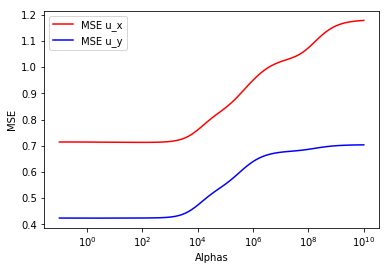

In [120]:
alphas=np.logspace(-1,10,100)

#leave one out method is used
clf_cv = RidgeCV(alphas, cv=None, store_cv_values=True)
clf_cv.fit(X_tr, y_tr) 

# number of datapoints, number of targets, number of alphas
# it already contains the mse
mse_all_folds=clf_cv.cv_values_
mse_means=np.mean(mse_all_folds, axis=0)
ax=plt.gca()
u_x,=ax.plot(alphas,mse_means[0],'r-',label='MSE u_x')
u_y,=ax.plot(alphas,mse_means[1],'b-',label='MSE u_y')
plt.xscale('log')
plt.xlabel('Alphas')
plt.ylabel('MSE')
ax.legend()

Optimize the ridge regression parameter with standardization

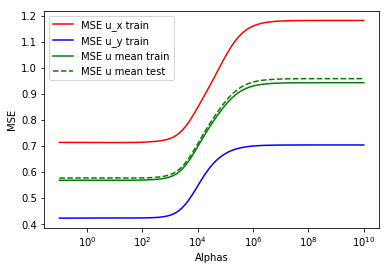

In [121]:
alphas=np.logspace(-1,10,100)

#stadardize the data

scaler = StandardScaler()
#define mean and standard based on the test data
scaler.fit(X_tr)
X_tr_scaled=scaler.transform(X_tr)
X_te_scaled=scaler.transform(X_te)


#leave one out method is used
clf_cv = RidgeCV(alphas, cv=None, store_cv_values=True)
clf_cv.fit(X_tr_scaled, y_tr) 

# number of datapoints, number of targets, number of alphas
# it already contains the mse
mse_all_folds=clf_cv.cv_values_
mse_means=np.mean(mse_all_folds, axis=0)
ax=plt.gca()

u_x_mse_train,=ax.plot(alphas,mse_means[0],'r-',label='MSE u_x train')
u_y_mse_train,=ax.plot(alphas,mse_means[1],'b-',label='MSE u_y train')
u_mean_mse_train,=ax.plot(alphas,np.mean(mse_means, axis=0),'g-',label='MSE u mean train')

mse_u_test=[]

for alpha in alphas:
    
    clf = Ridge(alpha)
    clf.fit(X_tr_scaled, y_tr) 
    mse_u_test.append(mean_squared_error(y_te,clf.predict(X_te_scaled)))
    
u_mse_test,=ax.plot(alphas,mse_u_test,'g--',label='MSE u mean test')

plt.xscale('log')
plt.xlabel('Alphas')
plt.ylabel('MSE')
ax.legend()

Get the mean squared error

0.5689818669371066

In [25]:
# what is this score??
clf.score(X_te, y_te)

0.39800262677619846